In [1]:
!pip install -q -U lightautoml catboost lightgbm xgboost

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
dask-expr 1.0.11 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
featuretools 1.30.0 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
fitter 1.7.0 requires joblib<2.0.0,>=1.3.1, but you have joblib 1.2.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
mizani 0.11.1 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatib

In [2]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [3]:
TARGET_NAME = 'FloodProbability'
TEST_SIZE = 0.1
N_THREADS = 4
TIMEOUT = 3600 * 11
N_FOLDS = 5
SEED = 27

In [4]:
np.random.seed(SEED)
torch.set_num_threads(N_THREADS)

In [5]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

# Preprocessing
- Using sum feature suggested by @ambrosm [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499274)
- Sorting features as suggested by @siukeitin [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499579)
- Adding a few other statistical features which have been suggested on the forums by various people

In [6]:
def add_stat_features(dataframe, cols):
    dataframe['_sum'] = dataframe[cols].sum(1)
    dataframe["_sum_log"] = np.log1p(dataframe["_sum"])
    dataframe['_mean'] = dataframe[cols].mean(1)
    dataframe['_median'] = dataframe[cols].median(1)
    dataframe['_max'] = dataframe[cols].max(1)
    dataframe['_min'] = dataframe[cols].min(1)
    dataframe['_mode'] = dataframe[cols].mode(1)[0]
    dataframe['_25th'] = dataframe[cols].quantile(0.25, axis=1)
    dataframe['_75th'] = dataframe[cols].quantile(0.75, axis=1)
    dataframe['_hmean'] = len(cols) / dataframe[cols].apply(lambda x: (1/x).mean(), axis=1)
    dataframe['_gmean'] = dataframe[cols].apply(lambda x: x.prod()**(1/len(x)), axis=1)
    dataframe['_2nd_moment'] = dataframe[cols].apply(lambda x: (x**2).mean(), axis=1)
    dataframe['_3rd_moment'] = dataframe[cols].apply(lambda x: (x**3).mean(), axis=1)
    dataframe['_entropy'] = dataframe[cols].apply(lambda x: -1*(x*np.log(x)).sum(), axis=1)
    sorted_features = [f"_sort_{i}" for i in np.arange(len(cols))]
    dataframe[sorted_features] = np.sort(dataframe[cols], axis=1)
    for i in range(10, 100, 10):
        dataframe[f'_{i}th'] = dataframe[cols].quantile(i/100, axis=1)

    return dataframe

In [7]:
feature_cols = list(test.columns)

train = add_stat_features(train, feature_cols)
train = train.drop(feature_cols, axis=1)

test = add_stat_features(test, feature_cols)
test = test.drop(feature_cols, axis=1)

In [8]:
_train, _val = train_test_split(
    train,
    test_size=TEST_SIZE,
    random_state=SEED
)

# Training

In [9]:
task = Task(
    name='reg',
    loss='mse',
    metric='r2',
    greater_is_better=True
)

In [10]:
automl = TabularUtilizedAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={
        'n_jobs': N_THREADS,
        'cv':  N_FOLDS,
        'random_state': SEED
    },
    tuning_params = {'max_tuning_time': 1800},
)

oof_preds = automl.fit_predict(
    _train,
    roles={'target': TARGET_NAME},
    verbose=1
)

[10:45:20] Start automl utilizator with listed constraints:
[10:45:20] - time: 39600.00 seconds
[10:45:20] - CPU: 4 cores
[10:45:20] - memory: 16 GB

[10:45:20] If one preset completes earlier, next preset configuration will be started

[10:45:20] ==================================================
[10:45:20] Start 0 automl preset configuration:
[10:45:20] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[10:45:20] Stdout logging level is INFO.
[10:45:20] Task: reg

[10:45:20] Start automl preset with listed constraints:
[10:45:20] - time: 39600.00 seconds
[10:45:20] - CPU: 4 cores
[10:45:20] - memory: 16 GB

[10:45:20] Train data shape: (1006161, 44)



/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[10:45:34] Layer 1 train process start. Time left 39585.83 secs
[10:45:38] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:45:42] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8449691693348609
[10:45:42] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:45:42] Time left 39578.19 secs

[10:45:43] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:50:32] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8690836455924983
[10:50:32] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[10:50:32] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1800.00 secs
[10:50:32] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[11:23:06] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[11:23:06] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[11:26:05] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8691266372825078
[11:26:

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[12:43:33] Layer 1 train process start. Time left 32506.95 secs
[12:43:36] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:43:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8449862068160432
[12:43:40] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:43:40] Time left 32499.80 secs

[12:44:38] Selector_LightGBM fitting and predicting completed
[12:44:39] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:49:23] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8690833695552145
[12:49:23] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:49:23] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1800.00 secs
[13:19:37] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[13:19:37] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[13:22:28] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8691232491658127
[13:22:28] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting an

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[16:35:06] Layer 1 train process start. Time left 18614.58 secs
[16:35:09] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:35:14] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8449743109279716
[16:35:14] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:35:14] Time left 18606.53 secs

[16:36:08] Selector_LightGBM fitting and predicting completed
[16:36:09] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[16:40:54] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.869079048811287
[16:40:54] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[16:40:54] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1800.00 secs
[17:10:59] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[17:10:59] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:15:25] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8691226012346687
[17:15:25] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[18:30:53] Layer 1 train process start. Time left 11667.26 secs
[18:30:57] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:31:01] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8450077367554273
[18:31:01] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:31:01] Time left 11658.67 secs

[18:31:02] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:35:39] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8690707825569669
[18:35:39] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:35:39] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1800.00 secs
[19:05:59] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[19:05:59] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[19:10:06] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8691336169382083
[19:10:06] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[19:10:06] Start fitting Lvl_0_Pipe_1_M

In [11]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.26011 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.40007 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.59993 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


	+ 0.33249 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.42100 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.57900 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


	+ 0.07841 * 1 averaged models with config = "conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.24255 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.75745 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



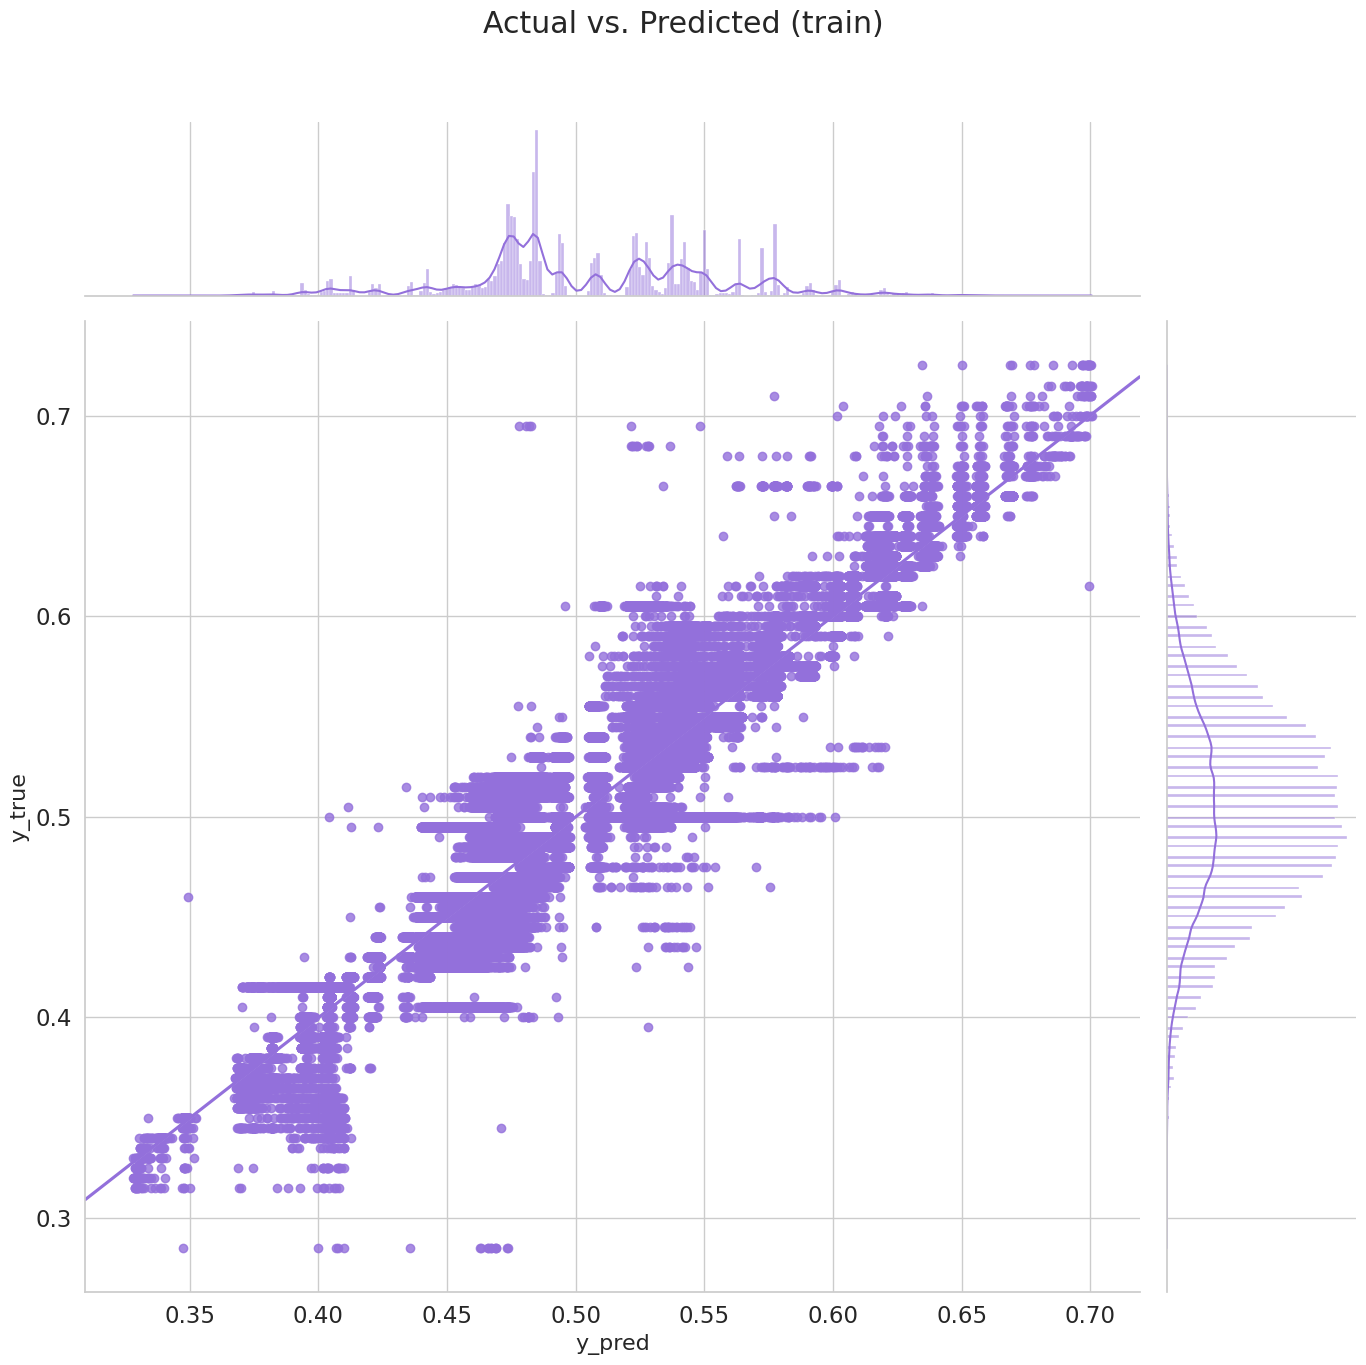

In [12]:
sns.set(style="whitegrid", font_scale=1.5)
g = sns.jointplot(
    x=oof_preds.data[:, 0],
    y=_train[TARGET_NAME],
    kind="reg",
    truncate=False,
    color='#9370DB',
    height=14,
)
g.set_axis_labels('y_pred', 'y_true', fontsize=16)
g.fig.suptitle("Actual vs. Predicted (train)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

# Evaluating The Model on the Validation Set

In [13]:
X_val = _val.drop(columns=[TARGET_NAME])
y_val = _val[TARGET_NAME].values

y_preds = automl.predict(X_val).data[:, 0]

score = r2_score(y_val, y_preds)

print(f'R2 score: {score}')

R2 score: 0.8693012314105817


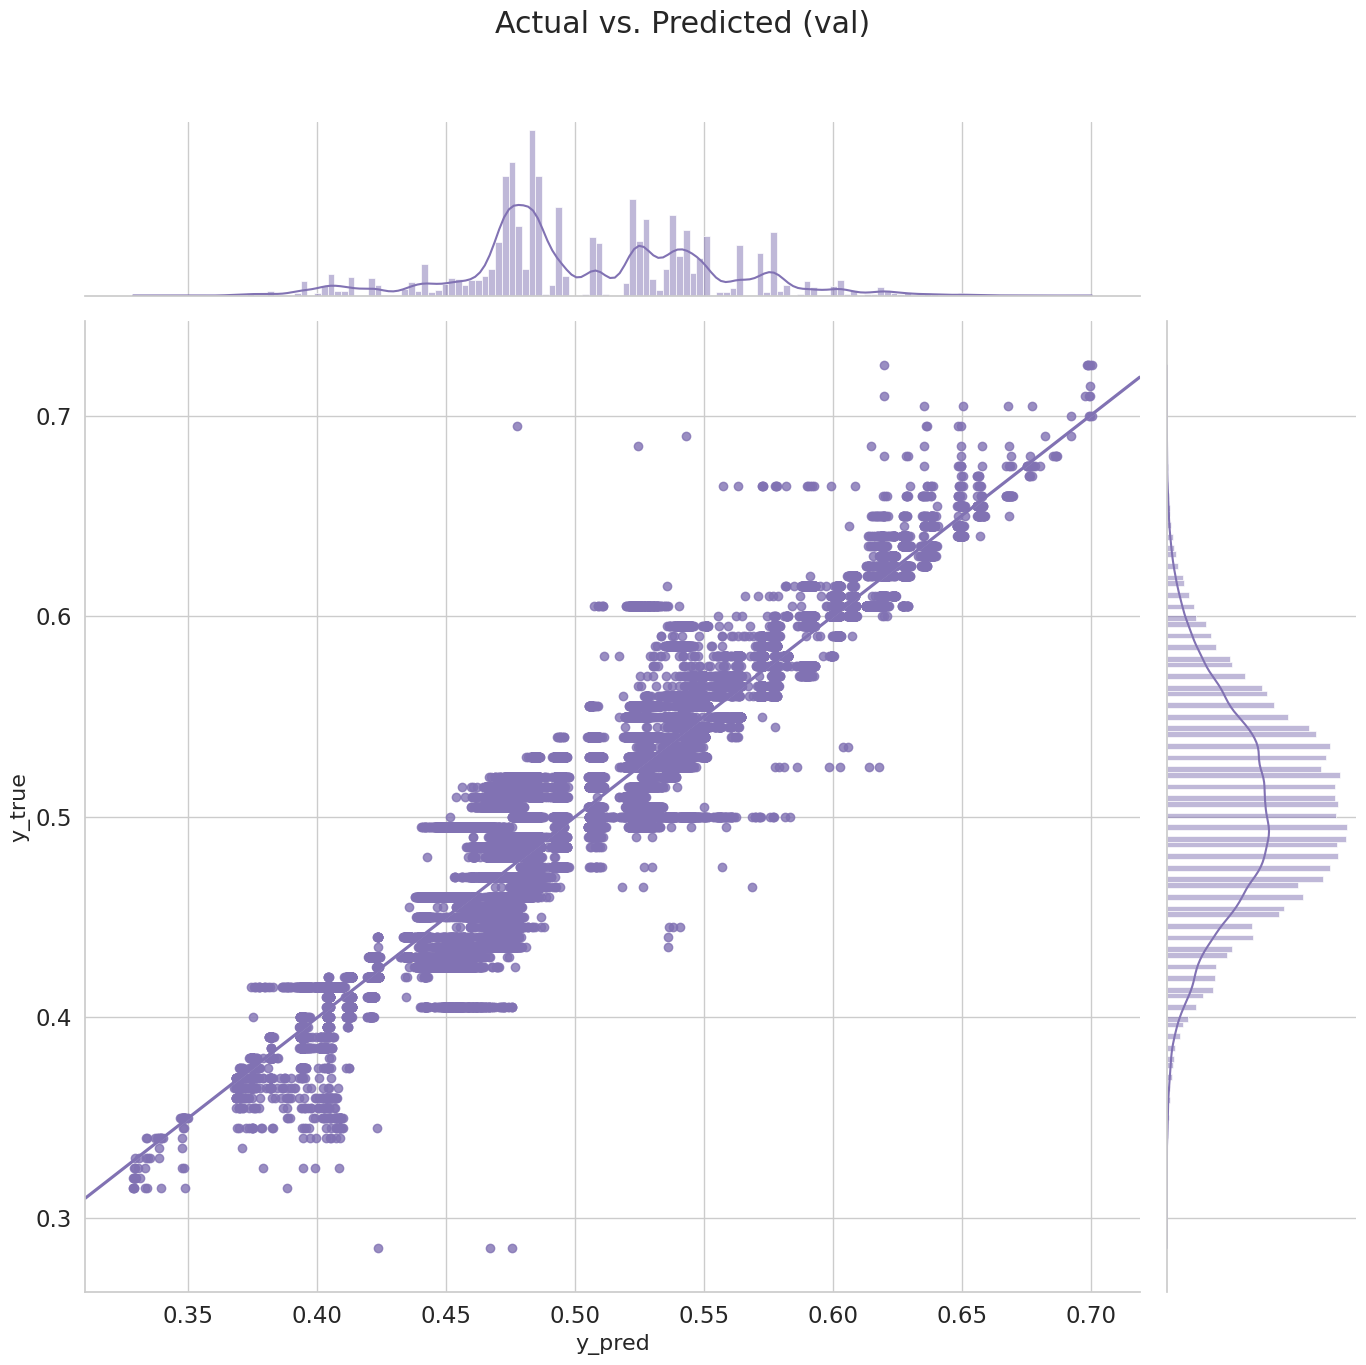

In [14]:
sns.set(style="whitegrid", font_scale=1.5)
g = sns.jointplot(
    x=y_preds,
    y=y_val,
    kind="reg",
    truncate=False,
    color='m',
    height=14,
)
g.set_axis_labels('y_pred', 'y_true', fontsize=16)
g.fig.suptitle("Actual vs. Predicted (val)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

# Making Predictions and Creating a Submission File

In [15]:
test_preds = automl.predict(test)
submission = pd.DataFrame({'id': test.index, 'FloodProbability': test_preds.data[:, 0]})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.578204
1,1117958,0.455849
2,1117959,0.447910
3,1117960,0.466563
4,1117961,0.466346
